In [2]:
import sys
import time
import warnings

import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

Parse the Data

In [8]:
from utils import *

problem = input("What problem? ")
if problem == 'infinite_slab':
    case = int(input("What case? "))
study = int(input("What study? "))

print("Loading and formating the data...")
t_start = time.time()
if problem == 'infinite_slab':
    dataset = get_data(problem, case, study)
else:
    dataset = get_data(problem, study)
t_end = time.time()
print(f"Loading the data took {t_end - t_start:3f} s")

Loading and formating the data...
Loading the data took 13.516287 s


KFold Cross Validation

In [9]:
from sklearn.model_selection import RepeatedKFold
from pyROMs.pod import POD

n_splits = 5
n_repeats = 500 // n_splits
interior_only = False

var = None
if problem != 'three_group_sphere':
    var = 'power_density'

X = dataset.create_dataset_matrix(var)
Y = dataset.parameters

tau = 1.0e-8 if problem != 'lra' else 1.0e-10
if problem == 'three_group_sphere':
    interp = 'rbf_gaussian' if study == 0 else 'rbf'
    epsilon = 5.0 if study == 0 else 200.0
elif problem == 'infinite_slab':
    interp = 'rbf'
    epsilon = 10.0
elif problem == 'twigl':
    interp = 'rbf'
    epsilon = 20.0
else:
    interp = 'rbf_gaussian'
    epsilon = 200.0

cv = {'mean': [], 'max': [], 'min': [],
      'const_time': [], 'query_time': []}

peak = {'mean': [], 'max': [], 'min': []}

# Define the cross validator and iterator
print(f"Starting Repeated K-Fold cross-validation study...")
cross_validator = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)
if interior_only:
    interior = dataset.interior_map
    iterator = cross_validator.split(X[interior], Y[interior])
else:
    iterator = cross_validator.split(X, Y)

# Perform the cross-validations
for train, test in iterator:
    if interior_only:
        boundary = dataset.boundary_map
        X_train, Y_train = X[interior][train], Y[interior][train]
        X_test, Y_test = X[interior][test], Y[interior][test]
        X_train = np.vstack((X_train, X[boundary]))
        Y_train = np.vstack((Y_train, Y[boundary]))
    else:
        X_train, Y_train = X[train], Y[train]
        X_test, Y_test = X[test], Y[test]

    # Construct the ROM
    t_start = time.time()
    pod = POD(svd_rank=1.0-tau)
    pod.fit(X_train, Y_train, interp, epsilon=epsilon)
    t_end = time.time()
    cv['const_time'].append(t_end - t_start)

    # Predict the results
    t_start = time.time()
    X_pred = pod.predict(Y_test)
    t_end = time.time()
    cv['query_time'].append((t_end-t_start)/len(test))

    # Format datasets and compute errors
    X_pred = dataset.unstack_simulation_vector(X_pred)
    X_test = dataset.unstack_simulation_vector(X_test)
    errors = np.zeros(len(X_test))
    for i in range(len(X_test)):
        errors[i] = norm(X_test[i]-X_pred[i])/ norm(X_test[i])
    cv['mean'].append(np.mean(errors))
    cv['min'].append(np.min(errors))
    cv['max'].append(np.max(errors))

    peak_errors = np.zeros(len(X_test))
    for i in range(len(X_test)):
        argmax = np.argmax(np.sum(X_test[i], axis=1))
        peak_errors[i] = norm(X_test[i][argmax]-X_pred[i][argmax])
        peak_errors[i] /= norm(X_test[i][argmax])
    peak['mean'].append(np.mean(peak_errors))
    peak['max'].append(np.max(peak_errors))
    peak['min'].append(np.min(peak_errors))

print()
print(f"Number of POD Modes:\t\t{pod.n_modes}")
print(f"Number of Snapshots:\t\t{pod.n_snapshots}")
print(f"Number of Validations:\t\t{len(X_test)}")
print(f"Average Construction Time:\t{np.mean(cv['const_time']):.3e} s")
print(f"Average Query Time:\t\t{np.mean(cv['query_time']):.3e} s")

Starting Repeated K-Fold cross-validation study...

Number of POD Modes:		8
Number of Snapshots:		100
Number of Validations:		25
Average Construction Time:	8.652e-02 s
Average Query Time:		4.853e-05 s


Plot the Results

Mean Statistics:
	Mean:	3.540e-03
	Median:	3.187e-03
	95% CI:	[1.934e-03, 8.189e-03]

Max Statistics:
	Mean:	1.685e-02
	Median:	1.309e-02
	95% CI:	[5.878e-03, 6.093e-02]

Min Statistics:
	Mean:	1.557e-04
	Median:	1.314e-04
	95% CI:	[9.307e-05, 3.939e-04]
/Users/zacharyhardy/Documents/phd/defense/figures/pulsed_neutron/error_distribution


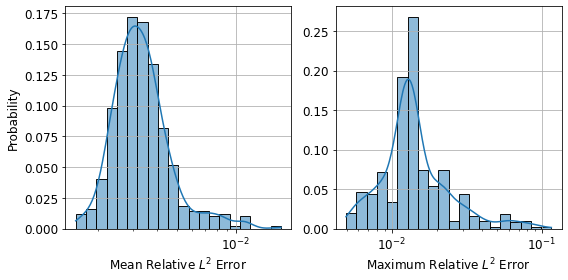

In [10]:
import seaborn as sb
from typing import List
import scipy.stats as stats
from matplotlib.pyplot import Figure, Axes

base = "/Users/zacharyhardy/Documents/phd/defense/figures"
if problem == 'three_group_sphere':
    if "dissertation" in base:
        base = f"{base}/chapter6"
    if "defense" in base:
        base = f"{base}/pulsed_neutron"
elif problem == 'infinite_slab':
    if "dissertation" in base:
        base = f"{base}/chapter7"
    if "defense" in base:
        base = f"{base}/infinite_slab"
elif problem == 'twigl':
    if "dissertation" in base:
        base = f"{base}/chapter8"
    if "defense" in base:
        base = f"{base}/twigl"
else:
    if "dissertation" in base:
        base = f"{base}/chapter9"
    if "defense" in base:
        base = f"{base}/lra"

conf_mean = np.percentile(cv['mean'], [2.5, 97.5])
conf_max = np.percentile(cv['max'], [2.5, 97.5])
conf_min = np.percentile(cv['min'], [2.5, 97.5])
print("Mean Statistics:")
print(f"\tMean:\t{np.mean(cv['mean']):.3e}")
print(f"\tMedian:\t{np.median(cv['mean']):.3e}")
print(f"\t95% CI:\t[{conf_mean[0]:.3e}, {conf_mean[1]:.3e}]")
print()
print("Max Statistics:")
print(f"\tMean:\t{np.mean(cv['max']):.3e}")
print(f"\tMedian:\t{np.median(cv['max']):.3e}")
print(f"\t95% CI:\t[{conf_max[0]:.3e}, {conf_max[1]:.3e}]")
print()
print("Min Statistics:")
print(f"\tMean:\t{np.mean(cv['min']):.3e}")
print(f"\tMedian:\t{np.median(cv['min']):.3e}")
print(f"\t95% CI:\t[{conf_min[0]:.3e}, {conf_min[1]:.3e}]")

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
fig: Figure = fig
axs: List[Axes] = axs.ravel()

for i, ax in enumerate(axs):
    data = cv['mean'] if i == 0 else cv['max']
    xlabel = "Mean " if i == 0 else "Maximum "
    ylabel = "Probability" if i == 0 else ""
    sb.histplot(data, bins=20, stat='probability',
                kde=True, log_scale=True, ax=ax)
    ax.tick_params(labelsize=12)
    ax.set_xlabel(xlabel + "Relative $L^2$ Error", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.grid(True)
plt.tight_layout()

if problem == 'three_group_sphere' and "defense" not in base:
    base += "radius/" if study == 0 else "results_3d"
    if study == 3:
        base += "/" if var is None else "_power/"

filename = f"{base}/error_distribution"
if interior_only:
    filename += "_interior"
print(filename)
# plt.savefig(f"{filename}.pdf")

if problem == 'lra':
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    fig: Figure = fig
    axs: List[Axes] = axs.ravel()

    for i, ax in enumerate(axs):
        data = peak['mean'] if i == 0 else peak['max']
        xlabel = "Mean " if i == 0 else "Maximum "
        ylabel = "Probability" if i == 0 else ""
        sb.histplot(data, bins=20, stat='probability',
                    kde=True, log_scale=True, ax=ax)
        ax.set_xlabel(xlabel + "Relative $L^2$ Error", fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)
        ax.grid(True)
    plt.tight_layout()

    filename = f"{base}/peak_error_distribution"
    if interior_only:
        filename += "_interior"
    # plt.savefig(f"{filename}.pdf")

Write LaTeX Table

In [11]:
msg = "\\begin{tabular}{|c|c|}"
msg += "\n\t\hline"
msg += "\n\t\\textbf{Quantity} & \\textbf{Value} \\\\ \hline\hline"
msg += f"\n\tMean of Set Means & {np.mean(cv['mean']):.3e} \\\\ \hline"
msg += f"\n\tMaximum of Set Means & {np.max(cv['mean']):.3e} \\\\ \hline"
msg += f"\n\tMinimum of Set Means & {np.min(cv['mean']):.3e} \\\\ \hline"
msg += f"\n\tMean of Set Maximums & {np.mean(cv['max']):.3e} \\\\ \hline"
msg += f"\n\tMaximum of Set Maximums & {np.max(cv['max']):.3e} \\\\ \hline"
msg += f"\n\tMean of Set Minimums & {np.mean(cv['min']):.3e} \\\\ \hline"
msg += f"\n\tMinimum of Set Minimums & {np.min(cv['min']):.3e} \\\\ \hline"
msg += f"\n\end{{tabular}}"
print(msg)
print()
msg = "\\begin{tabular}{|c|c|c|}"
msg += "\n\t\hline \\textbf{Quantity} & \\textbf{Mean Error} & " \
       "\\textbf{Max Error} \\\\ \hline"
msg += f"\n\tMean & {np.mean(cv['mean']):.3e} & " \
       f"{np.mean(cv['max']):.3e} \\\\ \hline"
msg += f"\n\tStd. Deviation & {np.std(cv['mean']):.3e} & " \
       f"{np.std(cv['max']):.3e} \\\\ \hline"
msg += f"\n\tMedian & {np.median(cv['mean']):.3e} & " \
       f"{np.median(cv['max']):.3e} \\\\ \hline"
msg += f"\n\t95\% Conf. Interval & [{conf_mean[0]:.3e}, {conf_mean[1]:.3e}] & " \
       f"[{conf_max[0]:.3e}, {conf_max[1]:.3e}] \\\\ \hline"
msg += f"\n\end{{tabular}}"
print(msg)


\begin{tabular}{|c|c|}
	\hline
	\textbf{Quantity} & \textbf{Value} \\ \hline\hline
	Mean of Set Means & 3.540e-03 \\ \hline
	Maximum of Set Means & 1.698e-02 \\ \hline
	Minimum of Set Means & 1.538e-03 \\ \hline
	Mean of Set Maximums & 1.685e-02 \\ \hline
	Maximum of Set Maximums & 1.155e-01 \\ \hline
	Mean of Set Minimums & 1.557e-04 \\ \hline
	Minimum of Set Minimums & 8.402e-05 \\ \hline
\end{tabular}

\begin{tabular}{|c|c|c|}
	\hline \textbf{Quantity} & \textbf{Mean Error} & \textbf{Max Error} \\ \hline
	Mean & 3.540e-03 & 1.685e-02 \\ \hline
	Std. Deviation & 1.565e-03 & 1.315e-02 \\ \hline
	Median & 3.187e-03 & 1.309e-02 \\ \hline
	95\% Conf. Interval & [1.934e-03, 8.189e-03] & [5.878e-03, 6.093e-02] \\ \hline
\end{tabular}
